# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [225]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [164]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [165]:
#Code below was gathered from Udacity Chat GPT and altered
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
file_path = '/workspace/home/image_preds.tsv'
with open(file_path, 'wb') as file:
    file.write(response.content)
    

image_preds = pd.read_csv('image_preds.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [166]:
#I have tried to used Tweepy to download the data but I recieved the following error: [{'message': 'You currently have access to a subset of Twitter API v2 endpoints and limited v1.1 endpoints (e.g. media post, oauth) only. If you need access to this endpoint, you may need a different access level. You can learn more here: https://developer.twitter.com/en/portal/product', 'code': 453}]
#Further investigation suggests I would need to pay for the basic package at $100 per month to access tweet info, therefore I have had to download tweet_json seperately.
response = requests.get('https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt')
file_path = '/workspace/home/tweet_json.txt'
with open(file_path, 'wb') as file:
    file.write(response.content)

In [167]:
#The following code was provided by Udacity GTP, I tried to convert the data from a text file, however I struggled with the dictionary layout of the text file.
with open('tweet_json.txt', 'r') as file:
    json_data = file.readlines()

tweet_data = []

for line in json_data:
    tweet = json.loads(line)
    tweet_data.append(tweet)

full_tweet_info = pd.DataFrame(tweet_data)



tweet_data = pd.DataFrame({
    'tweet_ID': full_tweet_info['id'],
    'retweet_count': full_tweet_info['retweet_count'],
    'favorite_count': full_tweet_info['favorite_count']
    })

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [168]:
twitter_archive.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

In [169]:
twitter_archive[twitter_archive['name'].isin(['a', 'an', 'my', 'his', 'the'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
759,778396591732486144,NaN,NaN,2016-09-21 00:53:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is an East African Chalupa...,7.030419e+17,4.196984e+09,2016-02-26 02:20:37 +0000,https://twitter.com/dog_rates/status/703041949...,10,10,an,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
852,765395769549590528,NaN,NaN,2016-08-16 03:52:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is my dog. Her name is Zoey. She knows I'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765395769...,13,10,my,None,None,None,None
992,748692773788876800,NaN,NaN,2016-07-01 01:40:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",That is Quizno. This is his beach. He does not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748692773...,10,10,his,doggo,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,None,None,None,None
1025,746369468511756288,NaN,NaN,2016-06-24 15:48:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Iraqi Speed Kangaroo. It is not a d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746369468...,9,10,an,None,None,None,None


In [170]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [171]:
twitter_archive[twitter_archive['retweeted_status_id'].isnull()==False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [172]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_ID          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [173]:
image_preds[(image_preds['p1_dog']==False)&(image_preds['p2_dog']==False)&(image_preds['p3_dog']==False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


In [174]:
# Percentage of unique image url's
image_preds.jpg_url.nunique()/image_preds.shape[0]

0.9681927710843373

### Quality issues
1. Incorrect Names in tweet_archive - a, an, my, his, the

2. Timestamp is an object rather than datetime in tweet_archive

3. Inconsistent column headers across dataframes - tweet_ID, tweet_id

4. Tweet id is set as an integer, however it would be best as a string in all 3 dataframes

5. The image prediction file contains rows that don't predict any dog breeds, these can be removed

6. in_reply_to_user_id, in_reply_to_status_id, retweeted_status_id, retweeted_status_user_id are currently floats but should all be int

7. Duplicate image_urls in the image_preds table

8. We can remove any tweets in the twitter_archive dataframe that have a retweeted_status_id to avoid duplicated data

### Tidiness issues
1. Duplicated columns - tweet ID in all 3 dataframes - we should be able to commbine into one column.

2. Stage of dog (doggo, floofer, pupper, puppo) can be one column

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [175]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
image_preds_clean = image_preds.copy()
tweet_data_clean = tweet_data.copy()

In [176]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue #1: Incorrect Names in tweet_archive - a, an, my, his, the

#### Define

Remove these values from the dataframe. These are examples of incorrect data, however it doesn't invalidate other data in the row and so we don't want to remove the entire row.

#### Code

In [177]:
bad_names = ['a', 'an', 'my', 'his', 'the','none']
twitter_archive_clean.name.replace(bad_names, np.nan,inplace=True)

#### Test

In [178]:
twitter_archive_clean[twitter_archive_clean['name'].isin(['a', 'an', 'my', 'his', 'the'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Issue #2: Timestamp is an object rather than datetime in tweet_archive

#### Define

Convert Timestamp and retwett timestamp column type to datetime

#### Code

In [179]:
timestamp_cols = ['timestamp','retweeted_status_timestamp']
for i in timestamp_cols:
    twitter_archive_clean[i]= pd.to_datetime(twitter_archive_clean[i])

#### Test

In [180]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2284 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime

### Issue 3: Inconsistent column headers across dataframes - tweet_ID, tweet_id

#### Define

Change the column header in the tweet_data dataframe from tweet_ID to tweet_id, in line with the other dataframes

#### Code

In [181]:
tweet_data_clean = tweet_data_clean.rename(columns={'tweet_ID': 'tweet_id'})

#### Test

In [182]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


### Issue 4: Tweet id is set as an integer, however it would be best as a string in all 3 dataframes

#### Define

As we will not need to perform any actions on the tweet id, it would be better suited as a string as it is more of an identifier.

#### Code

#### Test

In [183]:
twitter_archive_clean.info(),image_preds_clean.info(),tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2284 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime

(None, None, None)

In [184]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue 5: The image prediction file contains rows that don't predict any dog breeds, these can be removed

#### Define

We are only interested in images that contain dog preed predictions. Therefore any predictions that don't involve dogs can be ignored.

#### Code

In [185]:
image_preds_clean = image_preds_clean.loc[~((image_preds_clean['p1_dog']==False)&(image_preds_clean['p2_dog']==False)&(image_preds_clean['p3_dog']==False))]                                        

#### Test

In [186]:
image_preds_clean[(image_preds_clean['p1_dog']==False)&(image_preds_clean['p2_dog']==False)&(image_preds_clean['p3_dog']==False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Issue 6: in_reply_to_user_id, in_reply_to_status_id, retweeted_status_id, retweeted_status_user_id are currently floats but should all be strings

#### Define

#### Code

In [187]:
columns = ['in_reply_to_user_id', 'in_reply_to_status_id', 'retweeted_status_id', 'retweeted_status_user_id']

for i in columns:
    twitter_archive_clean[i] = twitter_archive_clean[i].astype(str)

#### Test

In [188]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2284 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: dateti

In [189]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue 7: Duplicate image_urls in the image_preds table

#### Define

Images appear in the table multiple times, we can drop these to avoid duplicate data

#### Code

In [190]:
#Code from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
image_preds_clean.drop_duplicates(subset=['jpg_url'],inplace = True)

#### Test

In [191]:
# This should now be one, every row is a unique image url
image_preds_clean.jpg_url.nunique()/image_preds_clean.shape[0]

1.0

### Issue 8: We can remove any tweets in the twitter_archive dataframe that have a retweeted_status_id to avoid duplicated data

#### Define

Retweeted tweets are a prime example of duplicate tweets. We can remove these.

#### Code

In [192]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id']=='nan']

#### Test

In [193]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [194]:
twitter_archive_clean[twitter_archive_clean['retweeted_status_id']!='nan']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Issue 9: Stage of dog (doggo, floofer, pupper, puppo) can be one column

#### Define

This information can be trimmed to one column

#### Code

In [195]:
twitter_archive_clean = pd.melt(twitter_archive_clean, 
                                id_vars = ['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'],
                                value_vars = ['doggo', 'floofer', 'pupper', 'puppo'], 
                                var_name = 'type', 
                                value_name = 'dog_stage')

twitter_archive_clean.drop('type', 1, inplace = True)

#### Test

In [197]:
twitter_archive_clean.dog_stage.value_counts()

None       8344
pupper      234
doggo        87
puppo        25
floofer      10
Name: dog_stage, dtype: int64

### Issue 10: Duplicated columns - tweet ID in all 3 dataframes - we should be able to commbine into one dataframe

#### Define

Rather than 3 seperate tables, we can join them all on ID

#### Code

In [198]:
temp_data = pd.merge(twitter_archive_clean, tweet_data_clean,on = ['tweet_id'], how = 'left')

full_clean_data = pd.merge(temp_data,image_preds_clean,on = ['tweet_id'], how = 'left')

#### Test

In [199]:
full_clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8700 entries, 0 to 8699
Data columns (total 22 columns):
tweet_id              8700 non-null int64
timestamp             8700 non-null datetime64[ns]
source                8700 non-null object
text                  8700 non-null object
expanded_urls         8468 non-null object
rating_numerator      8700 non-null int64
rating_denominator    8700 non-null int64
name                  8416 non-null object
dog_stage             8700 non-null object
retweet_count         8700 non-null int64
favorite_count        8700 non-null int64
jpg_url               6744 non-null object
img_num               6744 non-null float64
p1                    6744 non-null object
p1_conf               6744 non-null float64
p1_dog                6744 non-null object
p2                    6744 non-null object
p2_conf               6744 non-null float64
p2_dog                6744 non-null object
p3                    6744 non-null object
p3_conf               6744 

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [200]:
full_clean_data.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [201]:
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 23 columns):
Unnamed: 0            8700 non-null int64
tweet_id              8700 non-null int64
timestamp             8700 non-null object
source                8700 non-null object
text                  8700 non-null object
expanded_urls         8468 non-null object
rating_numerator      8700 non-null int64
rating_denominator    8700 non-null int64
name                  8416 non-null object
dog_stage             8700 non-null object
retweet_count         8700 non-null int64
favorite_count        8700 non-null int64
jpg_url               6744 non-null object
img_num               6744 non-null float64
p1                    6744 non-null object
p1_conf               6744 non-null float64
p1_dog                6744 non-null object
p2                    6744 non-null object
p2_conf               6744 non-null float64
p2_dog                6744 non-null object
p3                    6744 non-null 

### Insights:
1. What dog stages appear most frequently?

In [202]:
df.dog_stage.value_counts()

None       8344
pupper      234
doggo        87
puppo        25
floofer      10
Name: dog_stage, dtype: int64

Of all the different stages, most of the dogs are described as 'Pupper'.

2. What is the most popular dog breed by favourites?

In [217]:
df.groupby('p1')['favorite_count'].sum().sort_values(ascending=False)[:1]

p1
golden_retriever    6786508
Name: favorite_count, dtype: int64

Here we can see that the most popular dog breed by total likes is a golden retriever.

3. Which dog stage received the highest average score by the we rate dogs twitter account?

In [218]:
df.groupby('dog_stage')['rating_numerator'].mean().sort_values(ascending=False)

dog_stage
None       13.302493
puppo      12.080000
floofer    11.800000
doggo      11.770115
pupper     10.820513
Name: rating_numerator, dtype: float64

Interestingly dogs that were not classified had a higher average rating by the twitter account. After that it was 'puppo', this was likely to be the case for smaller, younger dogs.

### Visualization

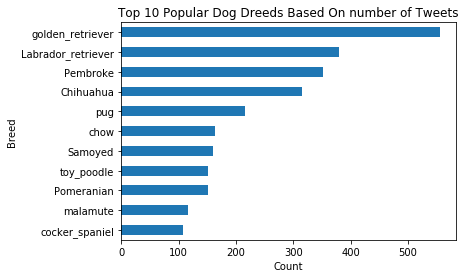

In [226]:
base_color = sb.color_palette()[0]

df.p1.value_counts()[10::-1].plot(kind = 'barh', title = 'Top Dog Breeds by Number of Tweets',color = base_color)
plt.ylabel('Dog Breed')
plt.xlabel('Tweet Count')

Sources:
    
Some Code was inspired by this github site: https://github.com/Monicajhe/Wrangle-and-Analyze-Data/blob/master/wrangle_act.ipynb